In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0
nfreq = 1

In [8]:
tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 0.5 * 2
monitor_blank = 0.5 * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = round(width_ag + width_sio2 + width_ag,2)
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

# 시뮬레이션 셀 크기
Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# 디자인 변수 격자
Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1  # 평면 구조

# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 1 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    # mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y)
]

In [9]:
# 셀 크기 설정
# cell_size = mp.Vector3(Sx*3, Sy)
cell_size = mp.Vector3(width_bot_ag*3, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [10]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

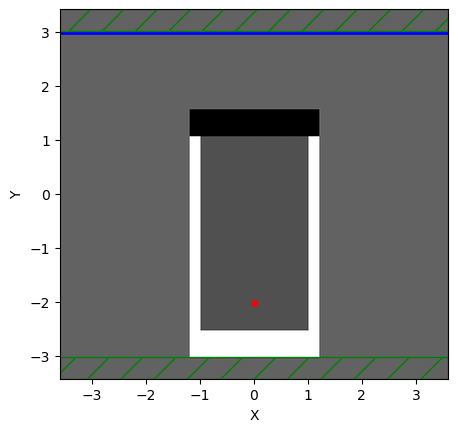

In [11]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]


k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        k_point=k0
    )
    for src in sources
]

monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(width_bot_ag*3, 0)

dft_monitor = sims[0].add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)


sims[0].plot2D()

     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


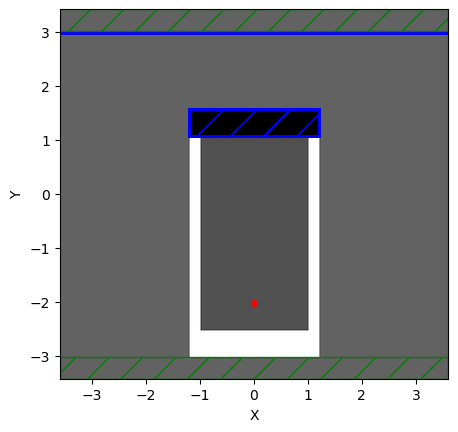

In [ ]:
monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(width_bot_ag*3, 0)

FourierFields_list = [
    mpa.FourierFields(
        sims[i],  
        mp.Volume(center=monitor_position_J, size=monitor_size),
        mp.Ez,
        yee_grid=True
    )
    for i in range(num_sources)
]


def J(fields):
    P_sum = 0.0

    for f in fields:
        arr = npa.atleast_1d(f)
        if arr.ndim >= 2:
            data = arr[0]
        else:
            data = arr
        Ez0 = npa.mean(data)
        P_sum += npa.abs(Ez0)**2

    return P_sum

def J(fields, ff_list):

    P_sum = 0.0

    for ff in ff_list:
        # 1) 모드 분해를 수행 (API 이름은 예시입니다: 실제 사용하시는 버전에 맞춰 바꿔주세요)
        #    mode_coeffs: [c0, c1, c2, ...] (각 모드 계수)
        #    mode_flux  : [F0, F1, F2, ...] (각 모드 Poynting flux)
        mode_coeffs, mode_flux = ff.compute_mode_decomposition()

        # 2) 0차 모드 계수 추출
        c0 = mode_coeffs[0]

        # 3) 0차 모드 세기 합산
        P_sum += abs(c0)**2

    return P_sum

opt_list = [
    mpa.OptimizationProblem(
        simulation=sims[i],
        objective_functions=[J],
        objective_arguments=[FourierFields_list[i]],
        design_regions=[design_region],  
        frequencies=[fcen],
        maximum_run_time=100,
    )
    for i in range(num_sources)
]
for i in range(num_sources):
    opt_list[i].plot2D(True)

In [14]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
         
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [15]:
eta_i = 0.5

def multi_mapping(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)


In [18]:
n = Nx * layer_num
np.random.seed(5)           
x = 0.4 + 0.2 * np.random.rand(n)  

cur_beta = 5

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny
    rho_list = [rho_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]

    f0_list = []
    dJ_list = []
    for i in range(len(opt_list)):
        f0_i, dJ_i = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
        f0_list.append(f0_i.flatten())
        dJ_list.append(dJ_i)

    dJ_total = np.mean(dJ_list, axis=0) # -> 3번째 트라이 바꾸는 부분
    dJ_flat = np.array(dJ_total).flatten()

    gradient_full = tensor_jacobian_product(multi_mapping, 0)(v, eta, beta, dJ_flat)

    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)
    v_new = np.concatenate(v_new_layers)

    f_vals = [float(np.abs(f0).item()) for f0 in f0_list]
    evaluation_history.append(f_vals)

    beta_history.append(beta)
    cur_iter[0] += 1

    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        # FoM 기준 변화율 계산 (여기 부분 계속 수정중)
        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.003 and change2 < 0.003) and (bin_change1 < 0.001 and bin_change2 < 0.00075):
            if beta < 8:
                beta *= 1.3
            else:
                beta = beta + 5*np.tanh((beta - 0.5)*0.03)
                

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")

    print(f"Binarization degree: {bin_deg:.4f}")

    # plt.figure(figsize=(3, 2))
    # ax = plt.gca()
    # opt_list[0].plot2D(
    #     False,
    #     output_plane=mp.Volume(
    #         size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
    #         center=mp.Vector3(0, full_center_y, 0)
    #     ),
    #     ax=ax,
    #     show_sources=False,
    #     show_monitors=False,
    #     show_boundary_layers=False,
    # )
    # ax.axis("off")
    # plt.show()

    return v_new, beta

mp.verbosity(0)
Max_iter = 300

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.99:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        print("FOM increases : ", )
        break


--- Iter 1 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.0003269438639666599]
Mean FoM: 0.000327
Binarization degree: 0.2028

--- Iter 2 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.0005151720659832073]
Mean FoM: 0.000515
Binarization degree: 0.2023

--- Iter 3 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.0010375295320055012]
Mean FoM: 0.001038
Binarization degree: 0.2026

--- Iter 4 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.001835447226488046]
Mean FoM: 0.001835
Binarization degree: 0.2039

--- Iter 5 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.0026843618767236088]
Mean FoM: 0.002684
Binarization degree: 0.2063

--- Iter 6 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.0021820690592139823]
Mean FoM: 0.002182
Binarization degree: 0.2140

--- Iter 7 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.004102273149550597]
Mean FoM: 0.004102
Binarization degree: 0.2146

--- Iter 8 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.005101799040835194]
Mean FoM: 0.005102
Binarization degree: 0.2184

--- Iter 9 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.008075566857809871]
Mean FoM: 0.008076
Binarization degree: 0.2274

--- Iter 10 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.010389457974643574]
Mean FoM: 0.010389
Binarization degree: 0.2419

--- Iter 11 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.009129870666674873]
Mean FoM: 0.009130
Binarization degree: 0.2585

--- Iter 12 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.013506387803552653]
Mean FoM: 0.013506
Binarization degree: 0.2741

--- Iter 13 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.015772649896977145]
Mean FoM: 0.015773
Binarization degree: 0.2866

--- Iter 14 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.01622485019043395]
Mean FoM: 0.016225
Binarization degree: 0.2982

--- Iter 15 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.017424619939555713]
Mean FoM: 0.017425
Binarization degree: 0.3107

--- Iter 16 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.017255271236495763]
Mean FoM: 0.017255
Binarization degree: 0.3228

--- Iter 17 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.02024687666114856]
Mean FoM: 0.020247
Binarization degree: 0.3335

--- Iter 18 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.02030992653919423]
Mean FoM: 0.020310
Binarization degree: 0.3437

--- Iter 19 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.01768855963915775]
Mean FoM: 0.017689
Binarization degree: 0.3527

--- Iter 20 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.019616887638037605]
Mean FoM: 0.019617
Binarization degree: 0.3610

--- Iter 21 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.02188017710531914]
Mean FoM: 0.021880
Binarization degree: 0.3680

--- Iter 22 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.022799100058340536]
Mean FoM: 0.022799
Binarization degree: 0.3747

--- Iter 23 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.02419432191595115]
Mean FoM: 0.024194
Binarization degree: 0.3827

--- Iter 24 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.02696267447484295]
Mean FoM: 0.026963
Binarization degree: 0.3895

--- Iter 25 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.029016704657349134]
Mean FoM: 0.029017
Binarization degree: 0.3955

--- Iter 26 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.030351560169643868]
Mean FoM: 0.030352
Binarization degree: 0.4001

--- Iter 27 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.030328778268814575]
Mean FoM: 0.030329
Binarization degree: 0.4039

--- Iter 28 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.020836005972612114]
Mean FoM: 0.020836
Binarization degree: 0.4090

--- Iter 29 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03011336710207058]
Mean FoM: 0.030113
Binarization degree: 0.4164

--- Iter 30 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.031407174274282815]
Mean FoM: 0.031407
Binarization degree: 0.4237

--- Iter 31 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.02886612878545014]
Mean FoM: 0.028866
Binarization degree: 0.4299

--- Iter 32 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.030986433463487152]
Mean FoM: 0.030986
Binarization degree: 0.4356

--- Iter 33 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03157067462561658]
Mean FoM: 0.031571
Binarization degree: 0.4395

--- Iter 34 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.030806171956781918]
Mean FoM: 0.030806
Binarization degree: 0.4427

--- Iter 35 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03220374592534312]
Mean FoM: 0.032204
Binarization degree: 0.4464

--- Iter 36 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03237084063134074]
Mean FoM: 0.032371
Binarization degree: 0.4489

--- Iter 37 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03241101588316833]
Mean FoM: 0.032411
Binarization degree: 0.4516

--- Iter 38 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03255786076310491]
Mean FoM: 0.032558
Binarization degree: 0.4557

--- Iter 39 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03133450548026861]
Mean FoM: 0.031335
Binarization degree: 0.4588

--- Iter 40 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03275979045247811]
Mean FoM: 0.032760
Binarization degree: 0.4621

--- Iter 41 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03269962906977174]
Mean FoM: 0.032700
Binarization degree: 0.4643

--- Iter 42 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03203186191542029]
Mean FoM: 0.032032
Binarization degree: 0.4659

--- Iter 43 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.0330914146637793]
Mean FoM: 0.033091
Binarization degree: 0.4676

--- Iter 44 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03237090868496779]
Mean FoM: 0.032371
Binarization degree: 0.4683

--- Iter 45 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03353851187571977]
Mean FoM: 0.033539
Binarization degree: 0.4692

--- Iter 46 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03355071878367479]
Mean FoM: 0.033551
Binarization degree: 0.4698

--- Iter 47 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03300443891236133]
Mean FoM: 0.033004
Binarization degree: 0.4711

--- Iter 48 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03357780717952864]
Mean FoM: 0.033578
Binarization degree: 0.4723

--- Iter 49 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03286454223688187]
Mean FoM: 0.032865
Binarization degree: 0.4730

--- Iter 50 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.033022946191905704]
Mean FoM: 0.033023
Binarization degree: 0.4738

--- Iter 51 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03328467675929195]
Mean FoM: 0.033285
Binarization degree: 0.4742

--- Iter 52 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03257510289914615]
Mean FoM: 0.032575
Binarization degree: 0.4739

--- Iter 53 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03342328851608102]
Mean FoM: 0.033423
Binarization degree: 0.4739

--- Iter 54 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03348005266857228]
Mean FoM: 0.033480
Binarization degree: 0.4735

--- Iter 55 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03279862106854717]
Mean FoM: 0.032799
Binarization degree: 0.4726

--- Iter 56 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03357721817654634]
Mean FoM: 0.033577
Binarization degree: 0.4720

--- Iter 57 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.032882059480365045]
Mean FoM: 0.032882
Binarization degree: 0.4708

--- Iter 58 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03266974318504685]
Mean FoM: 0.032670
Binarization degree: 0.4699

--- Iter 59 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03272054241762944]
Mean FoM: 0.032721
Binarization degree: 0.4691

--- Iter 60 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03211182219287884]
Mean FoM: 0.032112
Binarization degree: 0.4682

--- Iter 61 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03290898719467163]
Mean FoM: 0.032909
Binarization degree: 0.4678

--- Iter 62 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03270398040263467]
Mean FoM: 0.032704
Binarization degree: 0.4669

--- Iter 63 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.033084704652561095]
Mean FoM: 0.033085
Binarization degree: 0.4662

--- Iter 64 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03310105218889372]
Mean FoM: 0.033101
Binarization degree: 0.4654

--- Iter 65 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.032974710661519635]
Mean FoM: 0.032975
Binarization degree: 0.4645

--- Iter 66 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.0334217317396067]
Mean FoM: 0.033422
Binarization degree: 0.4639

--- Iter 67 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.032556823104067045]
Mean FoM: 0.032557
Binarization degree: 0.4629

--- Iter 68 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03309269770588875]
Mean FoM: 0.033093
Binarization degree: 0.4624

--- Iter 69 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.030858148972685143]
Mean FoM: 0.030858
Binarization degree: 0.4611

--- Iter 70 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03214177425385401]
Mean FoM: 0.032142
Binarization degree: 0.4610

--- Iter 71 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.030791623064163987]
Mean FoM: 0.030792
Binarization degree: 0.4601

--- Iter 72 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.032600542237679574]
Mean FoM: 0.032601
Binarization degree: 0.4601

--- Iter 73 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03288043628248456]
Mean FoM: 0.032880
Binarization degree: 0.4598

--- Iter 74 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03221945662966305]
Mean FoM: 0.032219
Binarization degree: 0.4593

--- Iter 75 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03333340199522153]
Mean FoM: 0.033333
Binarization degree: 0.4594

--- Iter 76 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03189794295466221]
Mean FoM: 0.031898
Binarization degree: 0.4584

--- Iter 77 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.033423759756757355]
Mean FoM: 0.033424
Binarization degree: 0.4587

--- Iter 78 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03306461289061803]
Mean FoM: 0.033065
Binarization degree: 0.4582

--- Iter 79 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.032489785078418223]
Mean FoM: 0.032490
Binarization degree: 0.4579

--- Iter 80 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03330890866858624]
Mean FoM: 0.033309
Binarization degree: 0.4582

--- Iter 81 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03241948084366651]
Mean FoM: 0.032419
Binarization degree: 0.4576

--- Iter 82 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.033294929097137424]
Mean FoM: 0.033295
Binarization degree: 0.4576

--- Iter 83 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03338984706294517]
Mean FoM: 0.033390
Binarization degree: 0.4572

--- Iter 84 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03260470386411099]
Mean FoM: 0.032605
Binarization degree: 0.4569

--- Iter 85 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.033759250032119874]
Mean FoM: 0.033759
Binarization degree: 0.4575

--- Iter 86 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03344739779310442]
Mean FoM: 0.033447
Binarization degree: 0.4570

--- Iter 87 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.033779882842259364]
Mean FoM: 0.033780
Binarization degree: 0.4570

--- Iter 88 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03408809034748484]
Mean FoM: 0.034088
Binarization degree: 0.4571

--- Iter 89 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03322713306551983]
Mean FoM: 0.033227
Binarization degree: 0.4565

--- Iter 90 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.033926404020259475]
Mean FoM: 0.033926
Binarization degree: 0.4566

--- Iter 91 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03368518545110139]
Mean FoM: 0.033685
Binarization degree: 0.4562

--- Iter 92 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03373336297403591]
Mean FoM: 0.033733
Binarization degree: 0.4559

--- Iter 93 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03419740329690109]
Mean FoM: 0.034197
Binarization degree: 0.4558

--- Iter 94 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03364951288067057]
Mean FoM: 0.033650
Binarization degree: 0.4550

--- Iter 95 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.034257064914699306]
Mean FoM: 0.034257
Binarization degree: 0.4549

--- Iter 96 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.034046786036092715]
Mean FoM: 0.034047
Binarization degree: 0.4543

--- Iter 97 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.034111800658658126]
Mean FoM: 0.034112
Binarization degree: 0.4541

--- Iter 98 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03441810945380565]
Mean FoM: 0.034418
Binarization degree: 0.4543

--- Iter 99 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03393511410143776]
Mean FoM: 0.033935
Binarization degree: 0.4537

--- Iter 100 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.0343575053569286]
Mean FoM: 0.034358
Binarization degree: 0.4540

--- Iter 101 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03397731390263454]
Mean FoM: 0.033977
Binarization degree: 0.4535

--- Iter 102 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.0342318266435919]
Mean FoM: 0.034232
Binarization degree: 0.4536

--- Iter 103 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.034317561313428134]
Mean FoM: 0.034318
Binarization degree: 0.4536

--- Iter 104 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03419390821197165]
Mean FoM: 0.034194
Binarization degree: 0.4534

--- Iter 105 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03451197286876731]
Mean FoM: 0.034512
Binarization degree: 0.4536

--- Iter 106 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03414021833324276]
Mean FoM: 0.034140
Binarization degree: 0.4532

--- Iter 107 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03454788744591984]
Mean FoM: 0.034548
Binarization degree: 0.4535

--- Iter 108 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03424853665801651]
Mean FoM: 0.034249
Binarization degree: 0.4531

--- Iter 109 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.034551820769171925]
Mean FoM: 0.034552
Binarization degree: 0.4533

--- Iter 110 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03434799615373376]
Mean FoM: 0.034348
Binarization degree: 0.4530

--- Iter 111 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03445360503078778]
Mean FoM: 0.034454
Binarization degree: 0.4530

--- Iter 112 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.0344377625804196]
Mean FoM: 0.034438
Binarization degree: 0.4529

--- Iter 113 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.034458718594736384]
Mean FoM: 0.034459
Binarization degree: 0.4529

--- Iter 114 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.026867267442115587]
Mean FoM: 0.026867
Binarization degree: 0.5169

--- Iter 115 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.030638521754078274]
Mean FoM: 0.030639
Binarization degree: 0.5152

--- Iter 116 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.032759717308801464]
Mean FoM: 0.032760
Binarization degree: 0.5173

--- Iter 117 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.019485768160555847]
Mean FoM: 0.019486
Binarization degree: 0.5183

--- Iter 118 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.02710771607569215]
Mean FoM: 0.027108
Binarization degree: 0.5234

--- Iter 119 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.02785407649245026]
Mean FoM: 0.027854
Binarization degree: 0.5235

--- Iter 120 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.0247952647033632]
Mean FoM: 0.024795
Binarization degree: 0.5206

--- Iter 121 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03125690361604684]
Mean FoM: 0.031257
Binarization degree: 0.5235

--- Iter 122 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.026072928817942476]
Mean FoM: 0.026073
Binarization degree: 0.5317

--- Iter 123 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.028991406683657343]
Mean FoM: 0.028991
Binarization degree: 0.5367

--- Iter 124 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.025929803227880945]
Mean FoM: 0.025930
Binarization degree: 0.5404

--- Iter 125 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.030537094779757062]
Mean FoM: 0.030537
Binarization degree: 0.5449

--- Iter 126 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03176673155967643]
Mean FoM: 0.031767
Binarization degree: 0.5477

--- Iter 127 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.031505729504991274]
Mean FoM: 0.031506
Binarization degree: 0.5474

--- Iter 128 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03373444680517143]
Mean FoM: 0.033734
Binarization degree: 0.5485

--- Iter 129 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.0331167515743885]
Mean FoM: 0.033117
Binarization degree: 0.5499

--- Iter 130 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03357945291707726]
Mean FoM: 0.033579
Binarization degree: 0.5504

--- Iter 131 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03319351459281657]
Mean FoM: 0.033194
Binarization degree: 0.5507

--- Iter 132 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03265496010294446]
Mean FoM: 0.032655
Binarization degree: 0.5528

--- Iter 133 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03249848040579471]
Mean FoM: 0.032498
Binarization degree: 0.5566

--- Iter 134 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03312897663578621]
Mean FoM: 0.033129
Binarization degree: 0.5602

--- Iter 135 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.031611234135524316]
Mean FoM: 0.031611
Binarization degree: 0.5635

--- Iter 136 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03356476278974099]
Mean FoM: 0.033565
Binarization degree: 0.5667

--- Iter 137 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.033664708213962655]
Mean FoM: 0.033665
Binarization degree: 0.5696

--- Iter 138 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.0340073011308038]
Mean FoM: 0.034007
Binarization degree: 0.5722

--- Iter 139 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03368703200872543]
Mean FoM: 0.033687
Binarization degree: 0.5743

--- Iter 140 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.034418938957557633]
Mean FoM: 0.034419
Binarization degree: 0.5765

--- Iter 141 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.034511812839114024]
Mean FoM: 0.034512
Binarization degree: 0.5779

--- Iter 142 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03419559817346983]
Mean FoM: 0.034196
Binarization degree: 0.5784

--- Iter 143 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.034557754630386565]
Mean FoM: 0.034558
Binarization degree: 0.5793

--- Iter 144 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03464038779243368]
Mean FoM: 0.034640
Binarization degree: 0.5801

--- Iter 145 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03466300350110611]
Mean FoM: 0.034663
Binarization degree: 0.5808

--- Iter 146 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.033976552070367774]
Mean FoM: 0.033977
Binarization degree: 0.5811

--- Iter 147 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03455627411428074]
Mean FoM: 0.034556
Binarization degree: 0.5814

--- Iter 148 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03468837331823394]
Mean FoM: 0.034688
Binarization degree: 0.5820

--- Iter 149 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03484547454362563]
Mean FoM: 0.034845
Binarization degree: 0.5822

--- Iter 150 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03459525332515654]
Mean FoM: 0.034595
Binarization degree: 0.5822

--- Iter 151 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03505152140995462]
Mean FoM: 0.035052
Binarization degree: 0.5820

--- Iter 152 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.03515328732981313]
Mean FoM: 0.035153
Binarization degree: 0.5820

--- Iter 153 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03515454391472238]
Mean FoM: 0.035155
Binarization degree: 0.5817

--- Iter 154 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.021325876116829318]
Mean FoM: 0.021326
Binarization degree: 0.6516

--- Iter 155 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.028812144390747984]
Mean FoM: 0.028812
Binarization degree: 0.6551

--- Iter 156 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.02579728315642059]
Mean FoM: 0.025797
Binarization degree: 0.6573

--- Iter 157 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.02931542617245601]
Mean FoM: 0.029315
Binarization degree: 0.6584

--- Iter 158 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.025827436713926236]
Mean FoM: 0.025827
Binarization degree: 0.6598

--- Iter 159 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.029916678873613663]
Mean FoM: 0.029917
Binarization degree: 0.6624

--- Iter 160 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.029773866190030022]
Mean FoM: 0.029774
Binarization degree: 0.6680

--- Iter 161 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03161912445964732]
Mean FoM: 0.031619
Binarization degree: 0.6705

--- Iter 162 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.029392025013510008]
Mean FoM: 0.029392
Binarization degree: 0.6703

--- Iter 163 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.030044833881750627]
Mean FoM: 0.030045
Binarization degree: 0.6735

--- Iter 164 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03212160104058431]
Mean FoM: 0.032122
Binarization degree: 0.6791

--- Iter 165 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03168440293910547]
Mean FoM: 0.031684
Binarization degree: 0.6817

--- Iter 166 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.032240905108882376]
Mean FoM: 0.032241
Binarization degree: 0.6814

--- Iter 167 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.030359570435346254]
Mean FoM: 0.030360
Binarization degree: 0.6821

--- Iter 168 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03275110459334208]
Mean FoM: 0.032751
Binarization degree: 0.6853

--- Iter 169 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.0318741243156341]
Mean FoM: 0.031874
Binarization degree: 0.6880

--- Iter 170 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.032704836868399756]
Mean FoM: 0.032705
Binarization degree: 0.6881

--- Iter 171 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03140105527559462]
Mean FoM: 0.031401
Binarization degree: 0.6869

--- Iter 172 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03176102403473849]
Mean FoM: 0.031761
Binarization degree: 0.6876

--- Iter 173 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03299752252882361]
Mean FoM: 0.032998
Binarization degree: 0.6897

--- Iter 174 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.032696783998134735]
Mean FoM: 0.032697
Binarization degree: 0.6905

--- Iter 175 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.032944577413212446]
Mean FoM: 0.032945
Binarization degree: 0.6896

--- Iter 176 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.031940708537765684]
Mean FoM: 0.031941
Binarization degree: 0.6892

--- Iter 177 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.033038502654876394]
Mean FoM: 0.033039
Binarization degree: 0.6905

--- Iter 178 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03288467301710268]
Mean FoM: 0.032885
Binarization degree: 0.6918

--- Iter 179 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03305883007310757]
Mean FoM: 0.033059
Binarization degree: 0.6914

--- Iter 180 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03216984037158566]
Mean FoM: 0.032170
Binarization degree: 0.6903

--- Iter 181 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03236189099582291]
Mean FoM: 0.032362
Binarization degree: 0.6906

--- Iter 182 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.033038468045609996]
Mean FoM: 0.033038
Binarization degree: 0.6917

--- Iter 183 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.033116832369882915]
Mean FoM: 0.033117
Binarization degree: 0.6918

--- Iter 184 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03308792952042771]
Mean FoM: 0.033088
Binarization degree: 0.6907

--- Iter 185 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.032810786227944616]
Mean FoM: 0.032811
Binarization degree: 0.6899

--- Iter 186 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03351610634642923]
Mean FoM: 0.033516
Binarization degree: 0.6903

--- Iter 187 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03354745878662879]
Mean FoM: 0.033547
Binarization degree: 0.6904

--- Iter 188 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.0335991838439942]
Mean FoM: 0.033599
Binarization degree: 0.6892

--- Iter 189 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03316916203330597]
Mean FoM: 0.033169
Binarization degree: 0.6880

--- Iter 190 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.033649100701745045]
Mean FoM: 0.033649
Binarization degree: 0.6880

--- Iter 191 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03374030316496175]
Mean FoM: 0.033740
Binarization degree: 0.6880

--- Iter 192 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03374957654352631]
Mean FoM: 0.033750
Binarization degree: 0.6868

--- Iter 193 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.033458885897848296]
Mean FoM: 0.033459
Binarization degree: 0.6857

--- Iter 194 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.0339058054591055]
Mean FoM: 0.033906
Binarization degree: 0.6857

--- Iter 195 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03404359125641106]
Mean FoM: 0.034044
Binarization degree: 0.6857

--- Iter 196 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03403766479235494]
Mean FoM: 0.034038
Binarization degree: 0.6847

--- Iter 197 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03396494039486767]
Mean FoM: 0.033965
Binarization degree: 0.6841

--- Iter 198 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.034360344258406623]
Mean FoM: 0.034360
Binarization degree: 0.6844

--- Iter 199 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.034434865165963176]
Mean FoM: 0.034435
Binarization degree: 0.6840

--- Iter 200 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03419465796320191]
Mean FoM: 0.034195
Binarization degree: 0.6836

--- Iter 201 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03448999369717521]
Mean FoM: 0.034490
Binarization degree: 0.6835

--- Iter 202 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.034589398945373724]
Mean FoM: 0.034589
Binarization degree: 0.6834

--- Iter 203 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03441611820970049]
Mean FoM: 0.034416
Binarization degree: 0.6829

--- Iter 204 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.034453342097271876]
Mean FoM: 0.034453
Binarization degree: 0.6828

--- Iter 205 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03457500137077075]
Mean FoM: 0.034575
Binarization degree: 0.6830

--- Iter 206 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.034449525968588524]
Mean FoM: 0.034450
Binarization degree: 0.6829

--- Iter 207 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.034345628864420816]
Mean FoM: 0.034346
Binarization degree: 0.6829

--- Iter 208 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03452638413976606]
Mean FoM: 0.034526
Binarization degree: 0.6833

--- Iter 209 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.0344727226958956]
Mean FoM: 0.034473
Binarization degree: 0.6832

--- Iter 210 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03435808638904613]
Mean FoM: 0.034358
Binarization degree: 0.6830

--- Iter 211 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03456267044301534]
Mean FoM: 0.034563
Binarization degree: 0.6833

--- Iter 212 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03455040812778349]
Mean FoM: 0.034550
Binarization degree: 0.6832

--- Iter 213 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03440463213984399]
Mean FoM: 0.034405
Binarization degree: 0.6831

--- Iter 214 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03453213988182347]
Mean FoM: 0.034532
Binarization degree: 0.6837

--- Iter 215 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03451382054309513]
Mean FoM: 0.034514
Binarization degree: 0.6843

--- Iter 216 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03436404965126596]
Mean FoM: 0.034364
Binarization degree: 0.6846

--- Iter 217 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.0344506652363266]
Mean FoM: 0.034451
Binarization degree: 0.6853

--- Iter 218 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.03449380062987877]
Mean FoM: 0.034494
Binarization degree: 0.6858

--- Iter 219 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 8.450
FoM values: [0.034418578969697036]
Mean FoM: 0.034419
Binarization degree: 0.6859

--- Iter 220 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.034486275685598186]
Mean FoM: 0.034486
Binarization degree: 0.6862

--- Iter 221 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.03279322085878137]
Mean FoM: 0.032793
Binarization degree: 0.7198

--- Iter 222 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.033168390510843734]
Mean FoM: 0.033168
Binarization degree: 0.7204

--- Iter 223 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.03191108221430992]
Mean FoM: 0.031911
Binarization degree: 0.7181

--- Iter 224 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.033931160337234895]
Mean FoM: 0.033931
Binarization degree: 0.7205

--- Iter 225 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.03417199573784872]
Mean FoM: 0.034172
Binarization degree: 0.7203

--- Iter 226 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.03333536820568405]
Mean FoM: 0.033335
Binarization degree: 0.7193

--- Iter 227 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.03329362516356165]
Mean FoM: 0.033294
Binarization degree: 0.7214

--- Iter 228 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.032540040864238784]
Mean FoM: 0.032540
Binarization degree: 0.7201

--- Iter 229 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.03368243557021359]
Mean FoM: 0.033682
Binarization degree: 0.7206

--- Iter 230 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.0338625835675823]
Mean FoM: 0.033863
Binarization degree: 0.7197

--- Iter 231 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.032958069653101836]
Mean FoM: 0.032958
Binarization degree: 0.7176

--- Iter 232 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.03363829130058177]
Mean FoM: 0.033638
Binarization degree: 0.7187

--- Iter 233 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.03422505458541249]
Mean FoM: 0.034225
Binarization degree: 0.7174

--- Iter 234 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.033736913717330834]
Mean FoM: 0.033737
Binarization degree: 0.7175

--- Iter 235 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.034165767467124415]
Mean FoM: 0.034166
Binarization degree: 0.7184

--- Iter 236 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.03374781073160022]
Mean FoM: 0.033748
Binarization degree: 0.7170

--- Iter 237 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.034072600376793175]
Mean FoM: 0.034073
Binarization degree: 0.7169

--- Iter 238 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.03417878295907728]
Mean FoM: 0.034179
Binarization degree: 0.7160

--- Iter 239 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.03389357893896535]
Mean FoM: 0.033894
Binarization degree: 0.7156

--- Iter 240 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.034061940223984725]
Mean FoM: 0.034062
Binarization degree: 0.7160

--- Iter 241 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.03380860875486632]
Mean FoM: 0.033809
Binarization degree: 0.7151

--- Iter 242 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.034241757592126484]
Mean FoM: 0.034242
Binarization degree: 0.7154

--- Iter 243 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 9.620
FoM values: [0.0343255874284185]
Mean FoM: 0.034326
Binarization degree: 0.7151

--- Iter 244 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03440583064899952]
Mean FoM: 0.034406
Binarization degree: 0.7148

--- Iter 245 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.033488472145136096]
Mean FoM: 0.033488
Binarization degree: 0.7448

--- Iter 246 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.033690429959767565]
Mean FoM: 0.033690
Binarization degree: 0.7428

--- Iter 247 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.033877942235930006]
Mean FoM: 0.033878
Binarization degree: 0.7435

--- Iter 248 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.02955469041380986]
Mean FoM: 0.029555
Binarization degree: 0.7402

--- Iter 249 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.020093102628427992]
Mean FoM: 0.020093
Binarization degree: 0.7448

--- Iter 250 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.02642295797176034]
Mean FoM: 0.026423
Binarization degree: 0.7438

--- Iter 251 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.01628330562005653]
Mean FoM: 0.016283
Binarization degree: 0.7371

--- Iter 252 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.011635243995319209]
Mean FoM: 0.011635
Binarization degree: 0.7395

--- Iter 253 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.018104260734021865]
Mean FoM: 0.018104
Binarization degree: 0.7453

--- Iter 254 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.018581486125962315]
Mean FoM: 0.018581
Binarization degree: 0.7521

--- Iter 255 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.015252304694747521]
Mean FoM: 0.015252
Binarization degree: 0.7537

--- Iter 256 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.01464943600131885]
Mean FoM: 0.014649
Binarization degree: 0.7538

--- Iter 257 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.019019705720230175]
Mean FoM: 0.019020
Binarization degree: 0.7524

--- Iter 258 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.02074988334509243]
Mean FoM: 0.020750
Binarization degree: 0.7493

--- Iter 259 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.019568796006682886]
Mean FoM: 0.019569
Binarization degree: 0.7527

--- Iter 260 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.018916560569671288]
Mean FoM: 0.018917
Binarization degree: 0.7576

--- Iter 261 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.018783254371648538]
Mean FoM: 0.018783
Binarization degree: 0.7636

--- Iter 262 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.018934915320905746]
Mean FoM: 0.018935
Binarization degree: 0.7687

--- Iter 263 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.019646699268005392]
Mean FoM: 0.019647
Binarization degree: 0.7748

--- Iter 264 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.02190907369073576]
Mean FoM: 0.021909
Binarization degree: 0.7796

--- Iter 265 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.02638207294564572]
Mean FoM: 0.026382
Binarization degree: 0.7846

--- Iter 266 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.027002768324250227]
Mean FoM: 0.027003
Binarization degree: 0.7899

--- Iter 267 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.033289323901578224]
Mean FoM: 0.033289
Binarization degree: 0.7916

--- Iter 268 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.027596210246064987]
Mean FoM: 0.027596
Binarization degree: 0.7929

--- Iter 269 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.030594119202595166]
Mean FoM: 0.030594
Binarization degree: 0.7964

--- Iter 270 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.028724767110827967]
Mean FoM: 0.028725
Binarization degree: 0.8001

--- Iter 271 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.02937720921463438]
Mean FoM: 0.029377
Binarization degree: 0.8014

--- Iter 272 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.028355233899568538]
Mean FoM: 0.028355
Binarization degree: 0.8012

--- Iter 273 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.027283370595048078]
Mean FoM: 0.027283
Binarization degree: 0.8016

--- Iter 274 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.030405372937940902]
Mean FoM: 0.030405
Binarization degree: 0.8031

--- Iter 275 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.031142606262495192]
Mean FoM: 0.031143
Binarization degree: 0.8045

--- Iter 276 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03343154334706415]
Mean FoM: 0.033432
Binarization degree: 0.8038

--- Iter 277 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.02891496201620013]
Mean FoM: 0.028915
Binarization degree: 0.8022

--- Iter 278 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03166524389761512]
Mean FoM: 0.031665
Binarization degree: 0.8030

--- Iter 279 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.029709767210918753]
Mean FoM: 0.029710
Binarization degree: 0.8053

--- Iter 280 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03198381781623934]
Mean FoM: 0.031984
Binarization degree: 0.8051

--- Iter 281 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.029497825700803008]
Mean FoM: 0.029498
Binarization degree: 0.8048

--- Iter 282 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03317809424810425]
Mean FoM: 0.033178
Binarization degree: 0.8064

--- Iter 283 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.032072771207306006]
Mean FoM: 0.032073
Binarization degree: 0.8079

--- Iter 284 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03263710591400469]
Mean FoM: 0.032637
Binarization degree: 0.8074

--- Iter 285 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.031094070274901808]
Mean FoM: 0.031094
Binarization degree: 0.8070

--- Iter 286 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.032704857044147426]
Mean FoM: 0.032705
Binarization degree: 0.8080

--- Iter 287 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.032642009537267286]
Mean FoM: 0.032642
Binarization degree: 0.8090

--- Iter 288 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.033111863146638665]
Mean FoM: 0.033112
Binarization degree: 0.8085

--- Iter 289 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.031231475140641764]
Mean FoM: 0.031231
Binarization degree: 0.8080

--- Iter 290 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03261909634355747]
Mean FoM: 0.032619
Binarization degree: 0.8089

--- Iter 291 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03244621770670336]
Mean FoM: 0.032446
Binarization degree: 0.8094

--- Iter 292 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03250743248194473]
Mean FoM: 0.032507
Binarization degree: 0.8088

--- Iter 293 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.032603350726561994]
Mean FoM: 0.032603
Binarization degree: 0.8091

--- Iter 294 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03318585470035703]
Mean FoM: 0.033186
Binarization degree: 0.8102

--- Iter 295 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03306827261247199]
Mean FoM: 0.033068
Binarization degree: 0.8103

--- Iter 296 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03243678948066755]
Mean FoM: 0.032437
Binarization degree: 0.8098

--- Iter 297 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.03297680987683314]
Mean FoM: 0.032977
Binarization degree: 0.8099

--- Iter 298 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.033317301432979736]
Mean FoM: 0.033317
Binarization degree: 0.8102

--- Iter 299 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 10.955
FoM values: [0.033260790789963655]
Mean FoM: 0.033261
Binarization degree: 0.8098

--- Iter 300 ---
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current β: 10.955
FoM values: [0.0323891622301888]
Mean FoM: 0.032389
Binarization degree: 0.8094


최대 FoM = 0.035155 는 iteration 153 에서 나왔습니다.


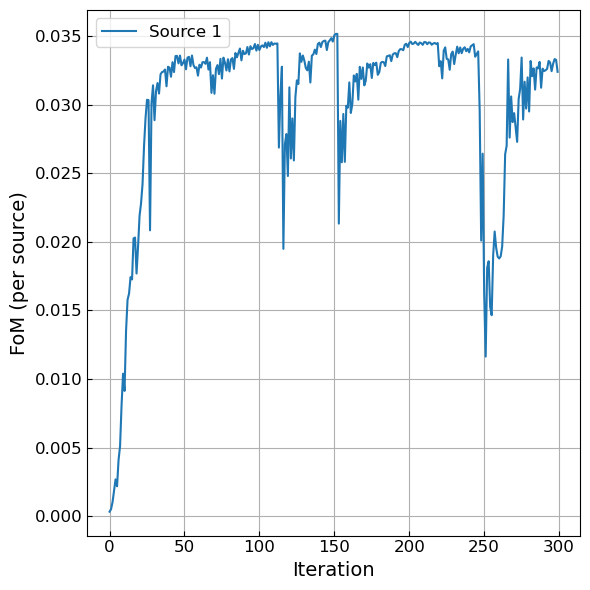

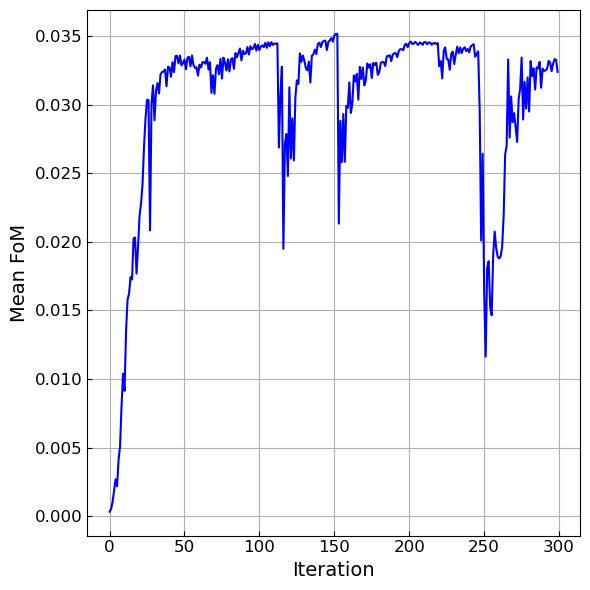

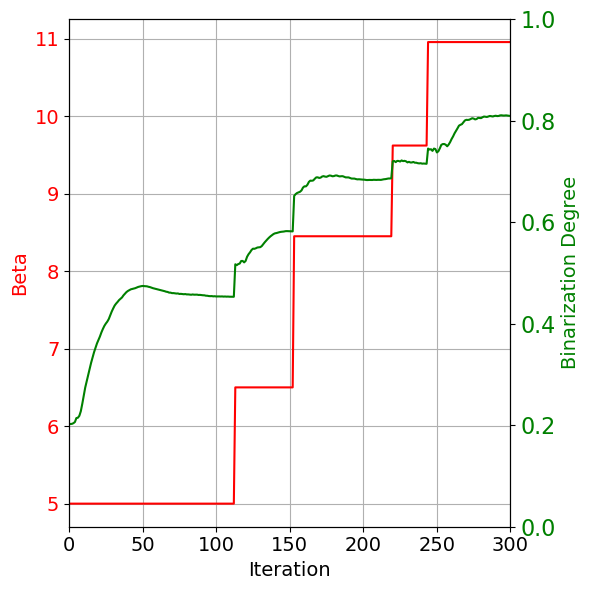

In [19]:
################ Find best FOM ################ 
eval_hist = np.array(evaluation_history)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

################ FOM plot ################ 
evaluation_array = np.array(evaluation_history)  
iterations = np.arange(len(evaluation_history))

###################### [1] 각 소스별 FoM plot ######################
plt.figure(figsize=(6, 6))

for i in range(evaluation_array.shape[1]):  # 각 소스별
    plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('FoM (per source)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

###################### [2] 평균 FoM plot ######################
plt.figure(figsize=(6, 6))

mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
plt.plot(iterations, mean_fom, 'b-', label='Mean FoM')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Mean FoM', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.tight_layout()
plt.show()

################ Combined Beta and Binarization Degree Plot ################ 
fig, ax1 = plt.subplots(figsize=(6,6))

color1 = 'red'
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Beta', color=color1, fontsize=14)
ax1.plot(beta_history, color=color1, label='Beta History')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0, np.array(cur_iter))
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.4, 1)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=16)

fig.tight_layout()
# plt.title('Beta & Binarization Degree', fontsize=15)
plt.show()